# Autoencoder Mini Project

#### You can get the dataset from https://www.kaggle.com/greysky/pencil-dataset

In [ ]:
import os, glob, json
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 50
BATCH_SIZE = 8

### Model Architecture

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
      nn.Conv2d(3, 8, 3, 2, 1),            # (n, 3, 128, 128) => (n, 8, 64, 64)
      nn.ReLU(),
      nn.Conv2d(8, 16, 3, 2, 1),            # (n, 8, 64, 64) => (n, 16, 32, 32)
      nn.ReLU(),
      nn.Conv2d(16, 32, 3, 2, 1),           # (n, 16, 32, 32) => (n, 32, 16, 16)
      nn.ReLU(),
      nn.Conv2d(32, 64, 3, 2, 1),           # (n, 32, 16, 16) => (n, 64, 8, 8)
      nn.ReLU(),
    )

    self.decoder = nn.Sequential(
      nn.ConvTranspose2d(64, 32, 2, 2),     # (n, 64, 8, 8) => (n, 32, 16, 16)
      nn.ReLU(),
      nn.ConvTranspose2d(32, 16, 2, 2),     # (n, 32, 16, 16) => (n, 16, 32, 32)
      nn.ReLU(),
      nn.ConvTranspose2d(16, 8, 2, 2),      # (n, 16, 32, 32) => (n, 8, 64, 64)
      nn.ReLU(),
      nn.ConvTranspose2d(8, 3, 2, 2),      # (n, 8, 64, 64) => (n, 3, 128, 128)
      nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

### Custom Dataset

In [ ]:
class PencilDataset(Dataset):
  def __init__(self, root, transform=None):
    super().__init__()
    self.root = root
    self.img_paths = glob.glob(f"{root}/*.jpg")
    self.transform = transform

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    image = Image.open(img_path)

    if self.transform:
      augmented = self.transform(image=np.array(image))
      image = augmented['image']
      image = torch.from_numpy(image)
      image = image.permute(2, 0, 1)
      image = image / 255.0
    
    return image, image

### Plot Function

In [ ]:
def plot_images(data_iter, n_samples):
  imgs, targets = next(data_iter)
  fig, axes = plt.subplots(1, n_samples, figsize=(20, 6))

  for img, target, ax in zip(imgs, targets, axes):
    ax.axis("off")
    ax.imshow(img.permute(1, 2, 0))

### Transforms

In [ ]:
train_transform = A.Compose([
    A.RandomCrop(height=800, width=800),
    A.RandomRotate90(p=1.0),
    A.Resize(height=128, width=128),
])

valid_transform = A.Compose([
    A.CenterCrop(height=800, width=800),
    A.Resize(height=128, width=128),
])

test_transform = A.Compose([
    A.CenterCrop(height=800, width=800),
    A.Resize(height=128, width=128),
])

### Dataset Initialization

In [ ]:
train_set = PencilDataset('dataset/train', transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
train_iter = iter(train_loader)

valid_set = PencilDataset('dataset/valid', transform=valid_transform)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)
valid_iter = iter(valid_loader)

test_set = PencilDataset('dataset/test', transform=test_transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)
test_iter = iter(test_loader)

### Train Samples

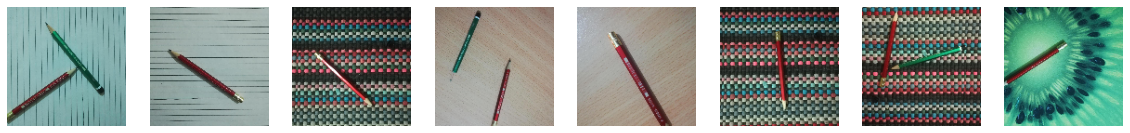

In [ ]:
plot_images(train_iter, 8)

### Valid Samples

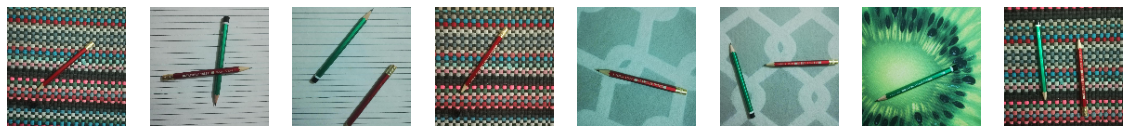

In [ ]:
plot_images(valid_iter, 8)

### Test Samples

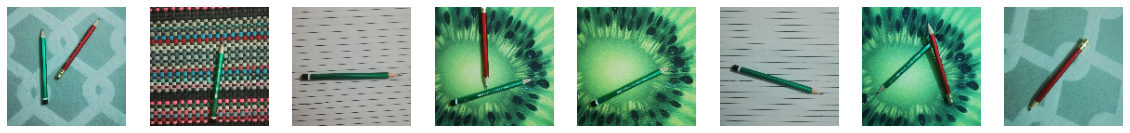

In [ ]:
plot_images(test_iter, 8)

### Model Initializaition

In [ ]:
model = Net().to(DEVICE)
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

### Train Function

In [ ]:
def train_fn(loader, model, optimizer, loss_fn):
  total_loss = 0.0
  model.train()

  for batch_idx, (x, y) in enumerate(loader):
    x, y = x.to(DEVICE), y.to(DEVICE)

    pred_y = model(x)
    loss = loss_fn(pred_y, y)
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return (total_loss / len(loader))

### Valid Function

In [ ]:
def valid_fn(loader, model, loss_fn):
  total_loss = 0.0
  model.eval()

  with torch.no_grad(): 
    for batch_idx, (x, y) in enumerate(loader):
      x, y = x.to(DEVICE), y.to(DEVICE)

      pred_y = model(x)
      total_loss += loss_fn(pred_y, y).item()
    
    return (total_loss / len(loader))

### Training

In [ ]:
train_y, valid_y = [], []
min_loss = 100.0

for i in range(NUM_EPOCHS):
  loss = train_fn(train_loader, model, optimizer, criterion)
  train_y.append(loss)

  vloss = valid_fn(valid_loader, model, criterion)
  valid_y.append(vloss)
  
  print('{0}.loss: {1:.4f}    vloss: {2:.4f}'.format(i + 1, loss, vloss))

  if (vloss < min_loss):
    min_loss = vloss
    torch.save(model.state_dict(), 'model.data')

1.loss: 0.0415    vloss: 0.0408
2.loss: 0.0410    vloss: 0.0408
3.loss: 0.0395    vloss: 0.0380
4.loss: 0.0386    vloss: 0.0366
5.loss: 0.0370    vloss: 0.0350
6.loss: 0.0341    vloss: 0.0333
7.loss: 0.0322    vloss: 0.0318
8.loss: 0.0304    vloss: 0.0280
9.loss: 0.0265    vloss: 0.0234
10.loss: 0.0218    vloss: 0.0198
11.loss: 0.0190    vloss: 0.0185
12.loss: 0.0183    vloss: 0.0177
13.loss: 0.0177    vloss: 0.0162
14.loss: 0.0173    vloss: 0.0170
15.loss: 0.0169    vloss: 0.0167
16.loss: 0.0169    vloss: 0.0161
17.loss: 0.0165    vloss: 0.0157
18.loss: 0.0161    vloss: 0.0153
19.loss: 0.0162    vloss: 0.0158
20.loss: 0.0158    vloss: 0.0153
21.loss: 0.0155    vloss: 0.0151
22.loss: 0.0153    vloss: 0.0150
23.loss: 0.0152    vloss: 0.0145
24.loss: 0.0146    vloss: 0.0142
25.loss: 0.0142    vloss: 0.0140
26.loss: 0.0140    vloss: 0.0132
27.loss: 0.0141    vloss: 0.0140
28.loss: 0.0134    vloss: 0.0128
29.loss: 0.0134    vloss: 0.0129
30.loss: 0.0129    vloss: 0.0135
31.loss: 0.0130    

### Loss Graph

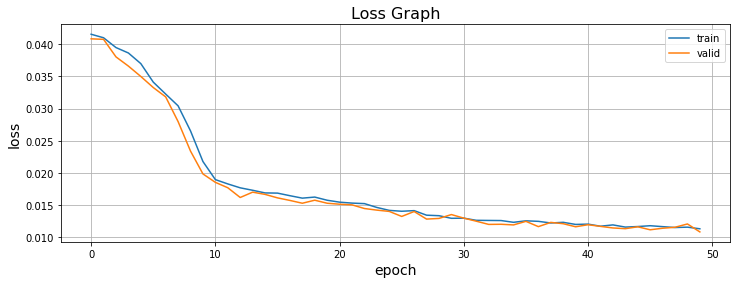

In [ ]:
plt.rcParams["figure.figsize"] = (12, 4)

plt.title('Loss Graph', fontsize=16)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)

plt.plot(train_y)
plt.plot(valid_y)
plt.legend(['train', 'valid'])
plt.grid()

plt.show()

### Plot Function

In [ ]:
def plot_predictions(data_iter, model, n_samples):
  imgs, targets = next(data_iter)

  model.eval()
  with torch.no_grad():
    preds = model(imgs.to(DEVICE)).to('cpu')

  fig, axes = plt.subplots(2, n_samples, figsize=(20, 6))

  for img, pred, ax in zip(imgs, preds, axes[0]):
    ax.axis("off")
    ax.imshow(pred.permute(1, 2, 0))

  for img, pred, ax in zip(imgs, preds, axes[1]):
    ax.axis("off")
    ax.imshow(img.permute(1, 2, 0))

### Testing

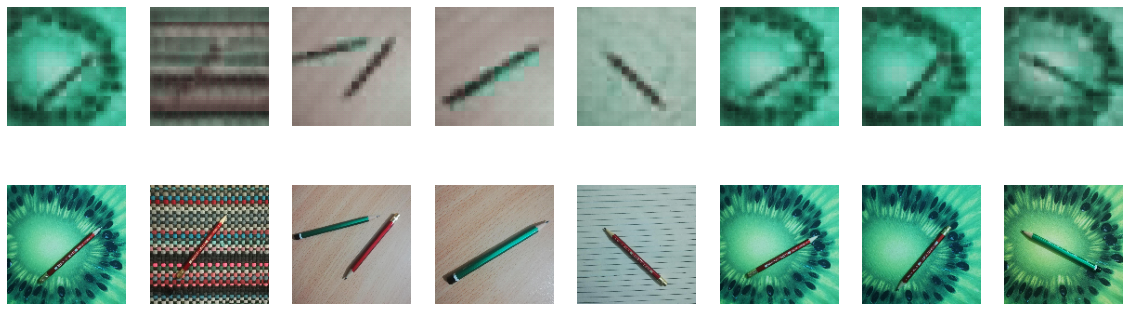

In [ ]:
plot_predictions(test_iter, model, 8)